<a href="https://colab.research.google.com/github/Dhanessss20/PCVK_Ganjil_2024/blob/main/Kuis2_Dhaneswara_%26_Reynald.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

100%|██████████| 639M/639M [00:22<00:00, 29.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/niten19/face-shape-dataset/versions/2
Found 4000 images belonging to 5 classes.
Found 1000 images belonging to 5 classes.
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


250/250 ━━━━━━━━━━━━━━━━━━━━ 227s 602ms/step - accuracy: 0.2395 - loss: 15.1005 - val_accuracy: 0.3620 - val_loss: 13.8434 - learning_rate: 0.0010
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 140s 544ms/step - accuracy: 0.3703 - loss: 13.5555 - val_accuracy: 0.4470 - val_loss: 12.5145 - learning_rate: 0.0010
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 145s 562ms/step - accuracy: 0.4822 - loss: 12.2210 - val_accuracy: 0.5340 - val_loss: 11.2960 - learning_rate: 0.0010
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 198s 548ms/step - accuracy: 0.5479 - loss: 11.0586 - val_accuracy: 0.5820 - val_loss: 10.2539 - learning_rate: 0.0010
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 140s 545ms/step - accuracy: 0.6177 - loss: 9.9807 - val_accuracy: 0.5910 - val_loss: 9.3821 - learning_rate: 0.0010
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 144s 562ms/step - accuracy: 0.6526 - loss: 9.0210 - val_accuracy: 0.6440 - val_loss: 8.4989 - learning_rate: 0.0010
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 143s 560ms/step - accuracy:

Test accuracy: 0.8140


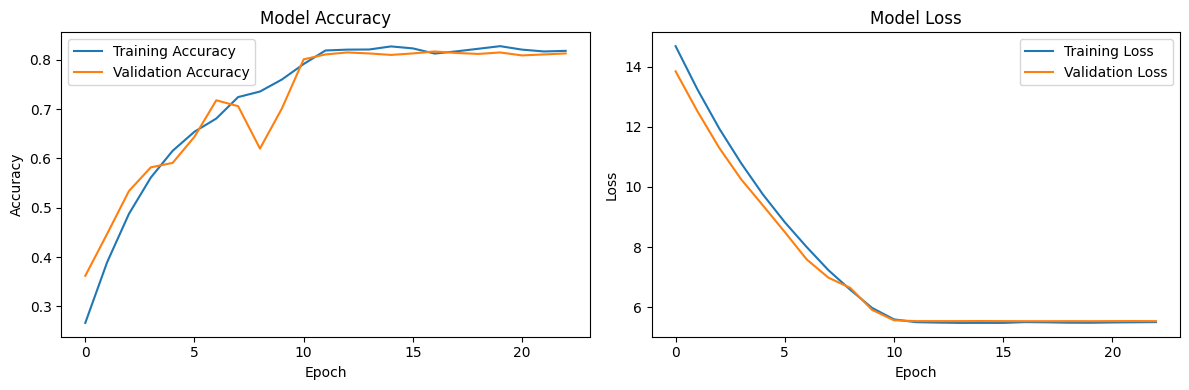

In [1]:
import kagglehub
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
from PIL import ImageFile
import numpy as np
import matplotlib.pyplot as plt

# Mengatasi gambar yang terpotong atau rusak
ImageFile.LOAD_TRUNCATED_IMAGES = True

# 1. Download the Dataset
path = kagglehub.dataset_download("niten19/face-shape-dataset")
print("Path to dataset files:", path)

# 2. Set Dataset Directory Paths
train_dir = path + "/FaceShape Dataset/training_set"
test_dir = path + "/FaceShape Dataset/testing_set"

# 3. Image Size Expected by InceptionV3
img_size = (299, 299)  # InceptionV3 input size
batch_size = 16  # Adjusted for better performance on smaller datasets

# 4. Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# 5. Image Generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# 6. Class Weights
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weight_dict = dict(enumerate(class_weights))

# 7. Build the Model Using InceptionV3
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Unfreeze more layers for fine-tuning
for layer in base_model.layers[-100:]:
    layer.trainable = True

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(1024, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

# 8. Compile the Model with SGD Optimizer
model.compile(
    optimizer=SGD(learning_rate=0.001, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.1

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    LearningRateScheduler(scheduler)
]

# 9. Train the Model
history = model.fit(
    train_generator,
    epochs=50,  # Increase epochs for more training
    validation_data=test_generator,
    class_weight=class_weight_dict,  # Use class weights
    callbacks=callbacks
)

# 10. Evaluate the Model on the Test Data
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc:.4f}')

# 11. Save the Model
model.save('face_shape_model_inceptionV3_tuned.h5')

# 12. Plot Training History
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# New Section

Pilih Gambar:
1. Ambil Foto
2. Upload Gambar
Masukkan pilihan (1/2): 2
Upload a file...


Saving contoh1.jpg to contoh1 (1).jpg
Uploaded file: contoh1 (1).jpg
Using uploaded file: contoh1 (1).jpg
Predicting face shape...
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


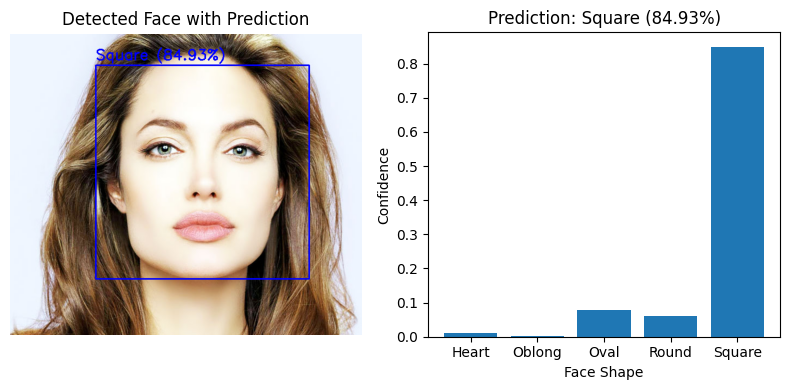

The predicted face shape is: Square with 84.93% confidence
Do you want to take/upload another photo? (yes/no): no
Exiting...


In [6]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
from google.colab.files import upload
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Fungsi untuk mengambil foto
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture Photo';
            div.appendChild(capture);
            document.body.appendChild(div);

            const video = document.createElement('video');
            div.appendChild(video);
            video.style.display = 'block';

            const stream = await navigator.mediaDevices.getUserMedia({video: true});
            video.srcObject = stream;
            await video.play();

            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getTracks().forEach(track => track.stop());
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

# Fungsi untuk mengunggah foto
def upload_photo():
    uploaded = upload()
    for filename in uploaded.keys():
        print(f'Uploaded file: {filename}')
        return filename

# Fungsi untuk deteksi wajah dan segmentasi
def preprocess_face(image_path):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(faces) == 0:
        print("No face detected.")
        return None, None, None

    x, y, w, h = faces[0]
    face = img[y:y+h, x:x+w]

    # Preprocessing
    resized_face = cv2.resize(face, (299, 299))
    normalized_face = resized_face / 255.0  # Normalize to [0, 1]

    return normalized_face, img, (x, y, w, h)

# Fungsi untuk memprediksi bentuk wajah
def predict_face_shape_and_display(image_path, model, img_size=(299, 299)):
    try:
        processed_face, original_img, bbox = preprocess_face(image_path)
        if processed_face is None:
            return None, None

        # Pastikan input memiliki 3 channel
        processed_face = np.expand_dims(processed_face, axis=0)  # Add batch dimension

        # Predict the class probabilities
        predictions = model.predict(processed_face)
        class_idx = np.argmax(predictions)
        confidence = np.max(predictions) * 100  # Convert confidence to percentage
        class_labels = ['Heart', 'Oblong', 'Oval', 'Round', 'Square']

        # Gambar bounding box dan prediksi
        if bbox:
            x, y, w, h = bbox
            cv2.rectangle(original_img, (x, y), (x+w, y+h), (255, 0, 0), 2)
            cv2.putText(original_img, f"{class_labels[class_idx]} ({confidence:.2f}%)",
                        (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

        # Tampilkan gambar dengan bounding box
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
        plt.title("Detected Face with Prediction")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.bar(class_labels, predictions[0])
        plt.title(f"Prediction: {class_labels[class_idx]} ({confidence:.2f}%)")
        plt.ylabel("Confidence")
        plt.xlabel("Face Shape")

        plt.tight_layout()
        plt.show()

        return class_labels[class_idx], confidence

    except Exception as e:
        print(f"Error processing image: {e}")
        return None, None

# Load model
# model = load_model('face_shape_model_inceptionV3_tuned.h5')
model = load_model('/content/face_shape_model_inceptionV3_tuned.h5')

# Main Loop: Ambil atau unggah foto, lalu prediksi
photo_count = 1
while True:
    try:
        print("Pilih Gambar:")
        print("1. Ambil Foto")
        print("2. Upload Gambar")
        choice = input("Masukkan pilihan (1/2): ").strip()

        if choice == '1':
            filename = f'photo_{photo_count}.jpg'
            print(f'Taking photo {photo_count}...')
            filename = take_photo(filename=filename)
            print(f'Saved to {filename}')
        elif choice == '2':
            print("Upload a file...")
            filename = upload_photo()
            print(f'Using uploaded file: {filename}')
        else:
            print("Pilihan tidak valid. Coba lagi.")
            continue

        # Prediksi bentuk wajah dari foto yang dipilih
        print("Predicting face shape...")
        predicted_shape, confidence = predict_face_shape_and_display(filename, model)
        print(f"The predicted face shape is: {predicted_shape} with {confidence:.2f}% confidence")

        # Tanya apakah ingin mengambil/mengunggah foto lagi
        take_another = input("Do you want to take/upload another photo? (yes/no): ").strip().lower()
        if take_another != 'yes':
            print("Exiting...")
            break
        photo_count += 1
    except Exception as e:
        print("Error:", str(e))
        break
